In [3]:
from julia.api import Julia
jl = Julia(compiled_modules=False)
from diffeqpy import de

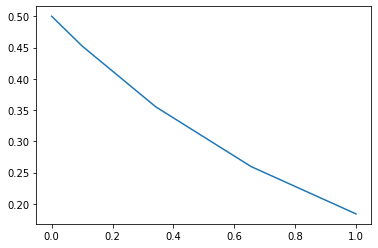

In [4]:
import matplotlib.pyplot as plt

def f(u,p,t):
    return -u

u0 = 0.5
tspan = (0., 1.)
prob = de.ODEProblem(f, u0, tspan)
sol = de.solve(prob)

plt.plot(sol.t,sol.u)
plt.show()

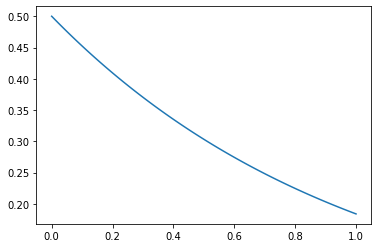

In [5]:
import numpy
t = numpy.linspace(0,1,100)
u = sol(t)
plt.plot(t,u)
plt.show()

In [6]:
sol = de.solve(prob,de.Vern9(),saveat=0.1,abstol=1e-10,reltol=1e-10)

In [7]:
from julia import Main
jul_f = Main.eval("(u,p,t)->-u") # Define the anonymous function in Julia
prob = de.ODEProblem(jul_f, u0, tspan)
sol = de.solve(prob)

#### Systems of ODEs: Lorenz Equations

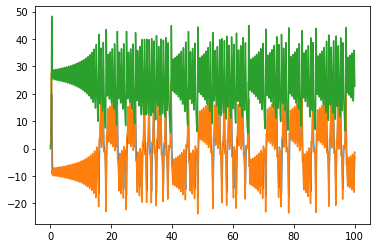

In [8]:
def f(u,p,t):
    x, y, z = u
    sigma, rho, beta = p
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

u0 = [1.0,0.0,0.0]
tspan = (0., 100.)
p = [10.0,28.0,8/3]
prob = de.ODEProblem(f, u0, tspan, p)
sol = de.solve(prob,saveat=0.01)

plt.plot(sol.t,sol.u)
plt.show()

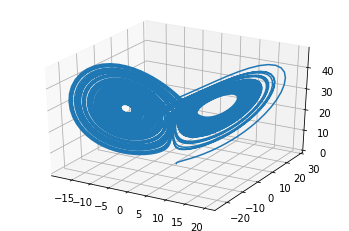

In [9]:
ut = numpy.transpose(sol.u)
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(ut[0,:],ut[1,:],ut[2,:])
plt.show()

#### In-Place Mutating Form

In [11]:
import numba
def f(du,u,p,t):
    x, y, z = u
    sigma, rho, beta = p
    du[0] = sigma * (y - x)
    du[1] = x * (rho - z) - y
    du[2] = x * y - beta * z

numba_f = numba.jit(f)
u0 = [1.0,0.0,0.0]
tspan = (0., 100.)
p = [10.0,28.0,2.66]
prob = de.ODEProblem(numba_f, u0, tspan, p)
sol = de.solve(prob)

using a Julia function:

In [12]:
jul_f = Main.eval("""
function f(du,u,p,t)
  x, y, z = u
  sigma, rho, beta = p
  du[1] = sigma * (y - x)
  du[2] = x * (rho - z) - y
  du[3] = x * y - beta * z
end""")
u0 = [1.0,0.0,0.0]
tspan = (0., 100.)
p = [10.0,28.0,2.66]
prob = de.ODEProblem(jul_f, u0, tspan, p)
sol = de.solve(prob)

#### Stochastic Differential Equation (SDE) Examples
-  [SDE tutorial](http://docs.juliadiffeq.org/dev/tutorials/sde_example.html)

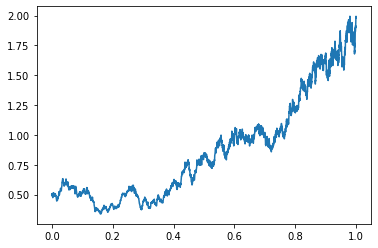

In [13]:
def f(u,p,t):
  return 1.01*u

def g(u,p,t):
  return 0.87*u

u0 = 0.5
tspan = (0.0,1.0)
prob = de.SDEProblem(f,g,u0,tspan)
sol = de.solve(prob,reltol=1e-3,abstol=1e-3)

plt.plot(sol.t,sol.u)
plt.show()

#### Systems of SDEs with Diagonal Noise

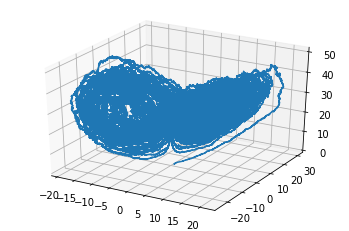

In [14]:
def f(du,u,p,t):
    x, y, z = u
    sigma, rho, beta = p
    du[0] = sigma * (y - x)
    du[1] = x * (rho - z) - y
    du[2] = x * y - beta * z

def g(du,u,p,t):
    du[0] = 0.3*u[0]
    du[1] = 0.3*u[1]
    du[2] = 0.3*u[2]

numba_f = numba.jit(f)
numba_g = numba.jit(g)
u0 = [1.0,0.0,0.0]
tspan = (0., 100.)
p = [10.0,28.0,2.66]
prob = de.SDEProblem(numba_f, numba_g, u0, tspan, p)
sol = de.solve(prob)

# Now let's draw a phase plot

ut = numpy.transpose(sol.u)
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(ut[0,:],ut[1,:],ut[2,:])
plt.show()

#### Systems of SDEs with Non-Diagonal Noise

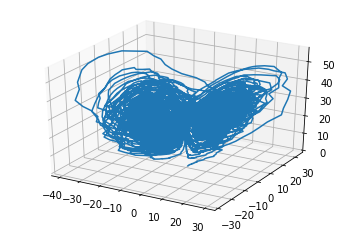

In [16]:
def f(du,u,p,t):
  x, y, z = u
  sigma, rho, beta = p
  du[0] = sigma * (y - x)
  du[1] = x * (rho - z) - y
  du[2] = x * y - beta * z

def g(du,u,p,t):
  du[0,0] = 0.3*u[0]
  du[1,0] = 0.6*u[0]
  du[2,0] = 0.2*u[0]
  du[0,1] = 1.2*u[1]
  du[1,1] = 0.2*u[1]
  du[2,1] = 0.3*u[1]


u0 = [1.0,0.0,0.0]
tspan = (0.0,100.0)
p = [10.0,28.0,2.66]
nrp = numpy.zeros((3,2))
numba_f = numba.jit(f)
numba_g = numba.jit(g)
prob = de.SDEProblem(numba_f,numba_g,u0,tspan,p,noise_rate_prototype=nrp)
sol = de.solve(prob,saveat=0.005)

ut = numpy.transpose(sol.u)
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(ut[0,:],ut[1,:],ut[2,:])
plt.show()

#### Delay Differential Equations

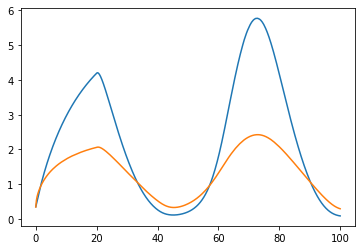

In [17]:
f = Main.eval("""
function f(du, u, h, p, t)
  du[1] = 1.1/(1 + sqrt(10)*(h(p, t-20)[1])^(5/4)) - 10*u[1]/(1 + 40*u[2])
  du[2] = 100*u[1]/(1 + 40*u[2]) - 2.43*u[2]
end""")
u0 = [1.05767027/3, 1.030713491/3]

h = Main.eval("""
function h(p,t)
  [1.05767027/3, 1.030713491/3]
end
""")

tspan = (0.0, 100.0)
constant_lags = [20.0]
prob = de.DDEProblem(f,u0,h,tspan,constant_lags=constant_lags)
sol = de.solve(prob,saveat=0.1)

u1 = [sol.u[i][0] for i in range(0,len(sol.u))]
u2 = [sol.u[i][1] for i in range(0,len(sol.u))]

import matplotlib.pyplot as plt
plt.plot(sol.t,u1)
plt.plot(sol.t,u2)
plt.show()